****Neural Network on Merged Data Minimizing Mean Absolute Percentage Error (MAPE)****

In [1]:
#Author: Bryant
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import keras_tuner as kt

In [2]:
random.seed(12345)

In [3]:
# Importing Data
toyota = pd.read_csv('Merged_Data_with_lag_Lead_Sales.csv', header=0)
toyota.head(20)

,Week,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
0,2020-10-04,AF,81,Region 1,365,283,343,164,37,6,...,4544,0,0,3792,3184,0,0,1,10,0
1,2020-10-11,AF,84,Region 1,311,303,267,160,5,7,...,2379,0,0,4941,3688,0,0,2,10,0
2,2020-10-18,AF,86,Region 1,165,353,102,297,7,8,...,1405,0,0,5874,4041,0,0,3,10,0
3,2020-10-25,AF,101,Region 1,84,343,73,296,2,11,...,233,0,0,5833,3301,0,0,4,10,0
4,2020-11-01,AF,79,Region 1,89,325,88,295,1,9,...,38,0,0,4671,2645,0,0,1,11,0
5,2020-11-08,AF,68,Region 1,105,321,114,285,5,8,...,150,0,0,5312,3314,0,0,2,11,0
6,2020-11-15,AF,79,Region 1,112,331,108,341,5,11,...,151,0,0,5242,3166,0,0,3,11,0
7,2020-11-22,AF,74,Region 1,84,375,58,297,7,14,...,11,0,0,4272,3209,0,0,4,11,0
8,2020-11-29,AF,81,Region 1,76,280,58,257,5,5,...,1554,0,0,4576,2625,0,0,5,11,0
9,2020-12-06,AF,59,Region 1,69,313,69,263,5,11,...,39969,0,0,4571,3052,0,0,1,12,0


In [4]:
toyota = toyota[toyota.Region != 'Region 13']

In [5]:
toyota.shape

(1500, 99)

In [6]:
covidcars = pd.read_csv('covid_sp_carz.csv', header=0)

In [7]:
covidcars.shape

(39, 23)

In [8]:
covidcars = covidcars.drop('Unnamed: 1',axis=1)
covidcars = covidcars.drop('SP_Date',axis=1)
covidcars = covidcars.drop('Carz_Date',axis=1)

In [9]:
covid = covidcars

In [10]:
toyota.index = pd.to_datetime(toyota['Week'])
toyota = toyota.drop(['Week'], axis= 1)

In [11]:
covid.index = pd.to_datetime(covid['date'])
covid = covid.drop(['date'], axis= 1)

In [12]:
toyota

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
Week,,,,,,,,,,,,,,,,,,,,,
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,4544,0,0,3792,3184,0,0,1,10,0
2020-10-11,AF,84,Region 1,311,303,267,160,5,7,1017,...,2379,0,0,4941,3688,0,0,2,10,0
2020-10-18,AF,86,Region 1,165,353,102,297,7,8,1022,...,1405,0,0,5874,4041,0,0,3,10,0
2020-10-25,AF,101,Region 1,84,343,73,296,2,11,902,...,233,0,0,5833,3301,0,0,4,10,0
2020-11-01,AF,79,Region 1,89,325,88,295,1,9,1049,...,38,0,0,4671,2645,0,0,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-21,AW,116,Region 9,52,124,43,110,1,4,4854,...,124,0,0,518,394,0,0,3,2,0
2021-02-28,AW,141,Region 9,46,105,53,114,1,1,4072,...,97,0,0,579,550,0,0,4,2,0
2021-03-07,AW,151,Region 9,43,96,46,85,0,2,3771,...,75,0,0,451,504,0,0,1,3,1


In [13]:
covid

,location,total_cases,new_cases,total_deaths,new_deaths,positive_rate,total_vaccinations,people_fully_vaccinated,new_vaccinations,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
date,,,,,,,,,,,,,,,,,,,
2020-10-04,United States,7420413,267696,209987,4583,0.045,NaN,NaN,NaN,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-11,United States,7772051,351638,215157,5170,0.044,NaN,NaN,NaN,3367.27,3482.34,3354.54,3477.13,39.860001,40.820000,39.689999,40.759998,149.70,33.803
2020-10-18,United States,8165987,393936,220380,5223,0.053,NaN,NaN,NaN,3500.02,3549.85,3440.89,3483.81,40.759998,41.200001,39.730000,40.599998,149.70,33.803
2020-10-25,United States,8662175,496188,226182,5802,0.057,NaN,NaN,NaN,3493.66,3502.42,3415.34,3465.39,40.389999,41.750000,40.330002,41.459999,149.70,33.803
2020-11-01,United States,9270686,608511,232209,6027,0.067,NaN,NaN,NaN,3441.42,3441.42,3233.94,3269.96,40.869999,41.209999,39.020000,39.349998,149.81,33.964
2020-11-08,United States,10087716,817030,239518,7309,0.080,NaN,NaN,NaN,3296.20,3529.05,3279.74,3509.44,40.509998,44.000000,40.509998,43.660000,149.81,34.930
2020-11-15,United States,11144834,1057118,247684,8166,0.099,NaN,NaN,NaN,3583.04,3645.99,3511.91,3585.15,45.860001,46.930000,44.570000,45.930000,149.81,34.930
2020-11-22,United States,12360893,1216059,258826,11142,0.095,NaN,NaN,NaN,3600.16,3628.51,3543.84,3557.54,46.570000,48.470001,46.570000,48.410000,149.81,34.930
2020-11-29,United States,13510377,1149484,269658,10832,0.101,NaN,NaN,NaN,3566.82,3644.31,3552.77,3638.35,48.990002,50.680000,48.990002,49.400002,149.81,34.930


In [14]:
pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,61,Region 10,199,361,129,93,4,1,1023,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,159,Region 11,264,213,110,63,4,2,2039,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,676,Region 12,20,8,23,6,0,0,3988,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,215,Region 2,509,855,168,231,6,10,2640,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,AW,313,Region 5,160,325,233,260,3,5,5082,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,344,Region 6,208,214,186,233,5,9,5515,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,86,Region 7,7,2,12,2,0,0,2447,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,311,Region 8,544,702,457,359,8,4,5598,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062


In [15]:
toyota = pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

In [16]:
# Selecting predictor variables
col_list = ['Sales', 'Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM',
            'Lead_Sales.Category_7','Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag1',
            'Lead_Sales.Category_7_lag4','Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag2','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2',
            'Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4','Lead_Sales.Category_9_lag1','Lead_Sales.Category_9_lag2','Impressions.Desktop.Display',
            'Qualified_Actions.NA.Search','Impressions.NA.Social','Impressions.Connected_TV.Video','Week_of_Month','Month_Number','total_deaths','new_deaths','positive_rate',
            'people_fully_vaccinated','new_vaccinations']

In [17]:
toyota = toyota[col_list]

In [18]:
toyota.shape

(1500, 35)

In [19]:
# Variance Inflation Factor (VIF)
def vif_arr(df):
    vif = pd.DataFrame()
    df=sma.add_constant(df)
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return(vif)

In [20]:
# Dummy Variables for Model
dummies_model = pd.get_dummies(toyota.Model)
dummies_model

,AF,AH,AL,AR,AW
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1


In [21]:
# Dummy Variables for Region (1-12, removing Region 13)
dummies_region = pd.get_dummies(toyota.Region)
dummies_region

,Region 1,Region 10,Region 11,Region 12,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,1,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,1,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,1,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,0,0,0,0,0,0,0,1,0,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,1,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,1,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Month = pd.get_dummies(toyota, columns=['Week_of_Month'])
dummies_Week_of_Month = dummies_Week_of_Month.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Month

,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0


In [23]:
# # Dummy Variables for Fin_Year_End (1-12)
# dummies_Fin_Year_End = pd.get_dummies(toyota, columns=['Fin_Year_End'])
# dummies_Fin_Year_End = dummies_Fin_Year_End.loc[:,'Fin_Year_End_0':'Fin_Year_End_1']
# dummies_Fin_Year_End

In [24]:
# Replacing old categorical features with dummy variables
newtoyota = pd.concat([toyota,dummies_model,dummies_region,dummies_Week_of_Month],axis='columns')

del newtoyota['Model']
del newtoyota['Region']
del newtoyota['Week_of_Month']

In [25]:
# Filling NA values
newtoyota = newtoyota.fillna(0)
# Checking the replaced NA values
# newtoyota.loc[:,'positive_rate':'new_vaccinations']

In [26]:
# Checks for empty columns and removes them
newtoyota=newtoyota.loc[:, (newtoyota.sum(axis=0) != 0)]

In [27]:
newtoyota.shape

(1500, 54)

In [28]:
newtoyota.head()

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,81,6,971,512,399,83,70,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,61,1,998,488,349,69,55,3,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,159,2,2187,975,768,171,153,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,676,0,4077,2073,1471,51,42,10,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,215,10,2797,1259,1034,177,141,2,4,1,...,0,0,0,0,0,1,0,0,0,0


In [29]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag1',
       'Lead_Sales.Category_7_lag4', 'Lead_Sales.Category_5_lag1',
       'Lead_Sales.Category_5_lag2', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Desktop.Display',
       'Qualified_Actions.NA.Search', 'Impressions.NA.Social',
       'Impressions.Connected_TV.Video', 'Month_Number', 'total_deaths',
       'new_deaths', 'positive_rate', 'people_fully_vaccinated',
       'new_vaccinations', 'AF', 'AH', 'AL', 'AR', 'AW', 'Region 1',
       'Region 10', 'Region 11', 'Region 12', 'Region 2', 'Region 3',
  

In [30]:
# # Checking Data Types, must change objects to numeric
# print(newtoyota.loc[:,'positive_rate':'SP_Close'].dtypes)

In [31]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(newtoyota, test_size=0.3)

In [32]:
# # Split Training and Testing Data
# train = newtoyota.sample(frac = 0.7, random_state=0)
# test = newtoyota.drop(train.index)

In [33]:
# Correlation Matrix for Continuous Variables
correlation_matrix = train.loc[:,'Sales':'new_vaccinations'].corr()
correlation_matrix

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Impressions.Desktop.Display,Qualified_Actions.NA.Search,Impressions.NA.Social,Impressions.Connected_TV.Video,Month_Number,total_deaths,new_deaths,positive_rate,people_fully_vaccinated,new_vaccinations
Sales,1.000000,0.089503,0.636387,0.311769,0.169035,0.201214,0.224807,0.221935,0.177828,-0.035648,...,0.170178,0.302236,0.007929,0.053182,0.017186,0.049979,-0.077447,-0.076781,0.102265,0.069798
CTA2.Paid.BAT,0.089503,1.000000,0.052677,0.020202,-0.064357,0.268722,0.266537,-0.184735,0.142094,0.053544,...,0.119631,0.243772,0.032475,0.061131,0.057917,-0.036544,-0.064090,-0.040148,-0.005247,-0.004746
Website_Visits.Paid.TCOM,0.636387,0.052677,1.000000,0.588325,0.545890,0.532906,0.585234,0.397599,0.230030,0.166604,...,0.206218,0.590436,0.196713,-0.019373,-0.179526,0.223264,0.085339,-0.081532,0.179547,0.204180
CTA1.Organic.TCOM,0.311769,0.020202,0.588325,1.000000,0.382328,0.585977,0.546036,0.478480,0.279654,0.269690,...,0.105527,0.266026,0.408197,-0.010354,0.018143,0.047007,0.146713,0.115829,-0.039688,-0.014370
CTA1.Paid.TCOM,0.169035,-0.064357,0.545890,0.382328,1.000000,0.338418,0.374563,0.478182,0.236665,0.237165,...,0.173306,0.282364,0.228165,0.068299,0.088538,0.022635,-0.172029,-0.123702,0.150467,0.111462
CTA2.Organic.TCOM,0.201214,0.268722,0.532906,0.585977,0.338418,1.000000,0.957235,0.271969,0.113590,0.389615,...,0.171474,0.360939,0.371505,0.087751,0.092119,-0.022141,-0.037383,0.000478,0.001143,0.000047
CTA2.Paid.TCOM,0.224807,0.266537,0.585234,0.546036,0.374563,0.957235,1.000000,0.274184,0.117751,0.387729,...,0.191445,0.452678,0.375256,0.140351,0.114976,-0.028568,-0.078749,-0.022671,0.032398,0.014299
Lead_Sales.Category_7,0.221935,-0.184735,0.397599,0.478480,0.478182,0.271969,0.274184,1.000000,0.508095,0.343664,...,0.108528,0.301944,0.305882,0.058234,0.057508,0.004809,-0.034131,0.001117,0.036290,0.014543
Lead_Sales.Category_5,0.177828,0.142094,0.230030,0.279654,0.236665,0.113590,0.117751,0.508095,1.000000,0.287234,...,0.121140,0.354760,0.228738,0.035662,-0.011836,0.093114,0.029668,-0.003894,0.092161,0.084908
Lead_Sales.Category_6,-0.035648,0.053544,0.166604,0.269690,0.237165,0.389615,0.387729,0.343664,0.287234,1.000000,...,0.115538,0.261914,0.198362,0.080138,0.017847,0.018333,-0.024751,-0.036090,0.031724,0.030780


In [34]:
abscorr = correlation_matrix.iloc[correlation_matrix.Sales.abs().argsort()]

In [35]:
abscorr.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Impressions.Desktop.Display,Qualified_Actions.NA.Search,Impressions.NA.Social,Impressions.Connected_TV.Video,Month_Number,total_deaths,new_deaths,positive_rate,people_fully_vaccinated,new_vaccinations
Sales,1.000000,0.089503,0.636387,0.311769,0.169035,0.201214,0.224807,0.221935,0.177828,-0.035648,...,0.170178,0.302236,0.007929,0.053182,0.017186,0.049979,-0.077447,-0.076781,0.102265,0.069798
Website_Visits.Paid.TCOM,0.636387,0.052677,1.000000,0.588325,0.545890,0.532906,0.585234,0.397599,0.230030,0.166604,...,0.206218,0.590436,0.196713,-0.019373,-0.179526,0.223264,0.085339,-0.081532,0.179547,0.204180
CTA1.Organic.TCOM,0.311769,0.020202,0.588325,1.000000,0.382328,0.585977,0.546036,0.478480,0.279654,0.269690,...,0.105527,0.266026,0.408197,-0.010354,0.018143,0.047007,0.146713,0.115829,-0.039688,-0.014370
Qualified_Actions.NA.Search,0.302236,0.243772,0.590436,0.266026,0.282364,0.360939,0.452678,0.301944,0.354760,0.261914,...,0.088869,1.000000,0.054934,-0.033660,-0.240237,0.320825,0.085518,-0.118492,0.285833,0.296862
Lead_Sales.Category_7_lag1,0.253592,-0.188424,0.388328,0.460158,0.404883,0.247121,0.239887,0.702044,0.490434,0.302325,...,0.067251,0.286691,0.242613,0.014313,-0.013678,0.065297,0.053687,0.082955,0.049939,0.033433
CTA2.Paid.TCOM,0.224807,0.266537,0.585234,0.546036,0.374563,0.957235,1.000000,0.274184,0.117751,0.387729,...,0.191445,0.452678,0.375256,0.140351,0.114976,-0.028568,-0.078749,-0.022671,0.032398,0.014299
Lead_Sales.Category_7,0.221935,-0.184735,0.397599,0.478480,0.478182,0.271969,0.274184,1.000000,0.508095,0.343664,...,0.108528,0.301944,0.305882,0.058234,0.057508,0.004809,-0.034131,0.001117,0.036290,0.014543
CTA2.Organic.TCOM,0.201214,0.268722,0.532906,0.585977,0.338418,1.000000,0.957235,0.271969,0.113590,0.389615,...,0.171474,0.360939,0.371505,0.087751,0.092119,-0.022141,-0.037383,0.000478,0.001143,0.000047
Lead_Sales.Category_7_lag4,0.178130,-0.183598,0.388109,0.456463,0.318544,0.204825,0.201966,0.626363,0.453746,0.273420,...,-0.079279,0.313789,0.244167,-0.119776,-0.117688,0.208531,0.322726,0.270852,0.056993,0.062842
Lead_Sales.Category_5,0.177828,0.142094,0.230030,0.279654,0.236665,0.113590,0.117751,0.508095,1.000000,0.287234,...,0.121140,0.354760,0.228738,0.035662,-0.011836,0.093114,0.029668,-0.003894,0.092161,0.084908


In [36]:
# Correlation for Continuous Variables Sorted by Sales Descending
correlation_matrix.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Impressions.Desktop.Display,Qualified_Actions.NA.Search,Impressions.NA.Social,Impressions.Connected_TV.Video,Month_Number,total_deaths,new_deaths,positive_rate,people_fully_vaccinated,new_vaccinations
Sales,1.000000,0.089503,0.636387,0.311769,0.169035,0.201214,0.224807,0.221935,0.177828,-0.035648,...,0.170178,0.302236,0.007929,0.053182,0.017186,0.049979,-0.077447,-0.076781,0.102265,0.069798
Website_Visits.Paid.TCOM,0.636387,0.052677,1.000000,0.588325,0.545890,0.532906,0.585234,0.397599,0.230030,0.166604,...,0.206218,0.590436,0.196713,-0.019373,-0.179526,0.223264,0.085339,-0.081532,0.179547,0.204180
CTA1.Organic.TCOM,0.311769,0.020202,0.588325,1.000000,0.382328,0.585977,0.546036,0.478480,0.279654,0.269690,...,0.105527,0.266026,0.408197,-0.010354,0.018143,0.047007,0.146713,0.115829,-0.039688,-0.014370
Qualified_Actions.NA.Search,0.302236,0.243772,0.590436,0.266026,0.282364,0.360939,0.452678,0.301944,0.354760,0.261914,...,0.088869,1.000000,0.054934,-0.033660,-0.240237,0.320825,0.085518,-0.118492,0.285833,0.296862
Lead_Sales.Category_7_lag1,0.253592,-0.188424,0.388328,0.460158,0.404883,0.247121,0.239887,0.702044,0.490434,0.302325,...,0.067251,0.286691,0.242613,0.014313,-0.013678,0.065297,0.053687,0.082955,0.049939,0.033433
CTA2.Paid.TCOM,0.224807,0.266537,0.585234,0.546036,0.374563,0.957235,1.000000,0.274184,0.117751,0.387729,...,0.191445,0.452678,0.375256,0.140351,0.114976,-0.028568,-0.078749,-0.022671,0.032398,0.014299
Lead_Sales.Category_7,0.221935,-0.184735,0.397599,0.478480,0.478182,0.271969,0.274184,1.000000,0.508095,0.343664,...,0.108528,0.301944,0.305882,0.058234,0.057508,0.004809,-0.034131,0.001117,0.036290,0.014543
CTA2.Organic.TCOM,0.201214,0.268722,0.532906,0.585977,0.338418,1.000000,0.957235,0.271969,0.113590,0.389615,...,0.171474,0.360939,0.371505,0.087751,0.092119,-0.022141,-0.037383,0.000478,0.001143,0.000047
Lead_Sales.Category_7_lag4,0.178130,-0.183598,0.388109,0.456463,0.318544,0.204825,0.201966,0.626363,0.453746,0.273420,...,-0.079279,0.313789,0.244167,-0.119776,-0.117688,0.208531,0.322726,0.270852,0.056993,0.062842
Lead_Sales.Category_5,0.177828,0.142094,0.230030,0.279654,0.236665,0.113590,0.117751,0.508095,1.000000,0.287234,...,0.121140,0.354760,0.228738,0.035662,-0.011836,0.093114,0.029668,-0.003894,0.092161,0.084908


In [37]:
# Pairplots
# sns.pairplot(train[['Sales', 'Qualified_Actions.Mobile.Display', 'Qualified_Actions.NA.Social', 'Lead_Sales.Category_7_lag1', 'Lead_Sales.Category_5', 'CTA2.Paid.BAT', 
#             'Impressions.Connected_TV.Video', 'Impressions.Mobile.Video', 'Impressions.Connected_TV.Display', 'Lead_Sales.Category_5_lag4', 'Lead_Sales.Category_7_lag2', 
#             'Lead_Sales.Category_7', 'Website_Visits.Paid.BAT','Website_Visits.Organic.BAT','Lead_Sales.Category_5_lag1','Qualified_Actions.Mobile.Video', 
#             'Impressions.Desktop.Display', 'Impressions.Mobile.Display', 'Impressions.NA.Search', 'Impressions.Unknown_Platform.Video', 'Lead_Sales.Category_7_lag4', 
#             'Lead_Sales.Category_8_lag1', 'Lead_Sales.Category_9', 'Lead_Sales.Category_9_lag4']], diag_kind='kde')

In [38]:
# Statistics of Training Data
trainstat = train.describe()
trainstat.pop('Sales')
trainstat = trainstat.transpose()
trainstat = trainstat.loc['CTA2.Paid.BAT':'new_vaccinations',:]

In [39]:
# Response Variable
trainlabel = train.pop('Sales')
testlabel = test.pop('Sales')

In [40]:
# Normalization
def normalize(x):
    return(x- trainstat['mean']) / trainstat['std']
norm_train = normalize(train.loc[:,'CTA2.Paid.BAT':'new_vaccinations'])
norm_test = normalize(test.loc[:,'CTA2.Paid.BAT':'new_vaccinations'])

In [41]:
trainlabel

2020-10-25     91
2021-03-07    131
2020-12-20    117
2021-03-07    231
2020-10-25    259
             ... 
2021-01-03    161
2021-03-14    341
2021-02-28    159
2020-11-29    148
2020-11-08    121
Name: Sales, Length: 1050, dtype: int64

In [42]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Impressions.Desktop.Display,Qualified_Actions.NA.Search,Impressions.NA.Social,Impressions.Connected_TV.Video,Month_Number,total_deaths,new_deaths,positive_rate,people_fully_vaccinated,new_vaccinations
2020-10-25,-0.256310,-1.349709,-0.973635,-0.894009,-0.984476,-1.007627,-1.177285,-0.840419,-0.731395,2.830545,...,1.996760,-0.875187,-1.300057,-0.463350,0.722486,-1.139384,-1.197724,-0.784186,-0.593488,-0.668398
2021-03-07,-0.746818,-1.114794,-1.021438,-0.871539,-0.696647,-0.879995,-0.884220,-0.840419,-0.731395,-0.275069,...,-0.081640,-0.782197,-0.925166,-0.727727,-0.790843,1.429447,-0.225981,-1.190215,1.691729,1.716746
2020-12-20,-0.910321,-0.587253,-0.576211,-0.467080,-0.260792,-0.135473,-0.298089,-0.840419,0.224975,-0.275069,...,-0.530447,0.087642,0.912156,0.345323,1.154865,-0.312944,0.960177,1.121026,-0.593488,-0.668398
2021-03-07,-0.256310,-0.759578,-0.901461,-0.673217,-0.647305,-0.826815,-1.177285,0.066508,2.137713,-0.275069,...,-0.081640,-0.782197,-0.925166,-0.727727,-0.790843,1.429447,-0.225981,-1.190215,1.691729,1.716746
2020-10-25,0.561204,-0.187329,-0.436550,-0.363523,0.059931,0.151700,0.874172,0.066508,0.224975,-0.275069,...,-0.372446,0.387751,-1.557343,-0.303820,0.722486,-1.139384,-1.197724,-0.784186,-0.593488,-0.668398


In [43]:
# Adding the categorical variables back into the training data.
norm_train = pd.concat([norm_train,train.loc[:,'AF':]],axis='columns')
norm_test = pd.concat([norm_test,test.loc[:,'AF':]],axis='columns')

In [44]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-25,-0.256310,-1.349709,-0.973635,-0.894009,-0.984476,-1.007627,-1.177285,-0.840419,-0.731395,2.830545,...,0,0,0,0,0,0,0,0,1,0
2021-03-07,-0.746818,-1.114794,-1.021438,-0.871539,-0.696647,-0.879995,-0.884220,-0.840419,-0.731395,-0.275069,...,0,0,0,0,0,1,0,0,0,0
2020-12-20,-0.910321,-0.587253,-0.576211,-0.467080,-0.260792,-0.135473,-0.298089,-0.840419,0.224975,-0.275069,...,0,0,0,0,0,0,0,1,0,0
2021-03-07,-0.256310,-0.759578,-0.901461,-0.673217,-0.647305,-0.826815,-1.177285,0.066508,2.137713,-0.275069,...,0,0,0,0,0,1,0,0,0,0
2020-10-25,0.561204,-0.187329,-0.436550,-0.363523,0.059931,0.151700,0.874172,0.066508,0.224975,-0.275069,...,1,0,0,0,0,0,0,0,1,0


In [45]:
# Building Neural Network with Hyperparameter Tuning
def buildmodel(hp):
    nn = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        nn.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    nn.add(layers.Dense(1, activation='linear'))
    nn.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2,1e-3,1e-4])),
        loss='mape',
        metrics=['mae', 'mape','mse'])
    return nn

In [46]:
tuner = kt.RandomSearch(buildmodel, objective = 'val_mape', max_trials = 10, executions_per_trial = 3, directory='finaltuning',project_name='ftoyotacovid1')

INFO:tensorflow:Reloading Oracle from existing project finaltuning\ftoyotacovid1\oracle.json
INFO:tensorflow:Reloading Tuner from finaltuning\ftoyotacovid1\tuner0.json


In [47]:
# Patience is amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor ='val_loss', patience=10)

In [48]:
tuner.search_space_summary()

Search space summary
Default search space size: 18
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [49]:
tuner.search(norm_train, trainlabel, epochs=50, validation_split=0.2, callbacks=[early_stop])

INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.results_summary()

Results summary
Results in finaltuning\ftoyotacovid1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 16
units_0: 352
units_1: 352
learning_rate: 0.01
units_2: 224
units_3: 224
units_4: 96
units_5: 416
units_6: 224
units_7: 256
units_8: 288
units_9: 352
units_10: 64
units_11: 416
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score: 14.62226422627767
Trial summary
Hyperparameters:
num_layers: 13
units_0: 256
units_1: 128
learning_rate: 0.01
units_2: 160
units_3: 128
units_4: 448
units_5: 96
units_6: 320
units_7: 416
units_8: 32
units_9: 192
units_10: 64
units_11: 32
units_12: 96
units_13: 64
units_14: 192
units_15: 192
Score: 15.141311009724935
Trial summary
Hyperparameters:
num_layers: 9
units_0: 512
units_1: 416
learning_rate: 0.001
units_2: 64
units_3: 224
units_4: 160
units_5: 384
units_6: 288
units_7: 384
units_8: 288
units_9: 448
units_10: 512
units_11: 416
units_12: 448
units_13: 224
units_14: 288
units_15: 320
Sc

In [51]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

def buildmodel():
    nn =keras.Sequential([
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    nn.compile(loss='mape',optimizer = optimizer,metrics=['mae', 'mape','mse'])
    return nn
nn = buildmodel()

nn.summary()

In [52]:
# Prints dots to show completion of one epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

**Finding the optimal number of epochs to train the model with the hyperparameters**

In [53]:
#Build best model with optimal hyperparameters
model = tuner.hypermodel.build(best_hps)      
history = model.fit(norm_train, trainlabel, epochs=50, validation_split = 0.2, callbacks =[PrintDot()])

val_mape_per_epoch = history.history['val_mape']
best_epoch = val_mape_per_epoch.index(min(val_mape_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
27/27 [==============================] - 1s 11ms/step - loss: 109.9623 - mae: 222.8042 - mape: 109.9623 - mse: 92273.0078 - val_loss: 97.9380 - val_mae: 237.9795 - val_mape: 97.9380 - val_mse: 85369.5312

.Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 64.6809 - mae: 144.8029 - mape: 64.6809 - mse: 43042.7539 - val_loss: 45.2585 - val_mae: 125.1122 - val_mape: 45.2585 - val_mse: 35870.1172
.Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 33.4304 - mae: 81.0818 - mape: 33.4304 - mse: 19040.6953 - val_loss: 36.0781 - val_mae: 105.7246 - val_mape: 36.0781 - val_mse: 26854.0039
.Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 29.0797 - mae: 68.6061 - mape: 29.0797 - mse: 13353.5967 - val_loss: 29.2937 - val_mae: 77.1254 - val_mape: 29.2937 - val_mse: 14822.4717
.Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 22.6584 - mae: 51.5451 - mape: 22.6584 - mse: 7044.2891 - val_loss: 21.8951

In [54]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(norm_train, trainlabel, epochs=best_epoch, validation_split = 0.2)

Epoch 1/50
27/27 [==============================] - 1s 10ms/step - loss: 271.8741 - mae: 403.8923 - mape: 271.8741 - mse: 1277376.2500 - val_loss: 77.2159 - val_mae: 199.6590 - val_mape: 77.2159 - val_mse: 66208.2734
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 46.4238 - mae: 108.0171 - mape: 46.4238 - mse: 26960.6641 - val_loss: 56.1690 - val_mae: 151.7458 - val_mape: 56.1690 - val_mse: 43088.1328
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 33.0961 - mae: 74.3841 - mape: 33.0961 - mse: 13643.5557 - val_loss: 25.8881 - val_mae: 67.8611 - val_mape: 25.8881 - val_mse: 10712.5166
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 24.9056 - mae: 55.2621 - mape: 24.9056 - mse: 7489.1958 - val_loss: 34.0551 - val_mae: 67.3617 - val_mape: 34.0551 - val_mse: 9189.5938
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 25.6616 - mae: 55.8923 - mape: 25.6616 - mse: 7144.2451 - val_loss: 21.9963 - val

In [55]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 352)               19008     
_________________________________________________________________
dense_1 (Dense)              (None, 352)               124256    
_________________________________________________________________
dense_2 (Dense)              (None, 224)               79072     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               50400     
_________________________________________________________________
dense_4 (Dense)              (None, 96)                21600     
_________________________________________________________________
dense_5 (Dense)              (None, 416)               40352     
_________________________________________________________________
dense_6 (Dense)              (None, 224)               9

In [56]:
#Training Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
0,109.962326,222.804245,109.962326,92273.007812,97.937950,237.979507,97.937950,85369.531250,0
1,64.680862,144.802917,64.680862,43042.753906,45.258541,125.112152,45.258541,35870.117188,1
2,33.430447,81.081787,33.430447,19040.695312,36.078094,105.724579,36.078094,26854.003906,2
3,29.079737,68.606110,29.079737,13353.596680,29.293715,77.125420,29.293715,14822.471680,3
4,22.658430,51.545105,22.658430,7044.289062,21.895096,56.265045,21.895096,8212.857422,4


In [57]:
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
45,9.098789,19.936089,9.098789,993.329407,14.925932,35.139580,14.925932,2730.643799,45
46,10.612934,23.017221,10.612934,1257.675415,18.118683,37.841377,18.118683,3063.118164,46
47,11.021706,24.350023,11.021706,1411.342163,13.504638,28.674795,13.504638,1614.198242,47
48,9.034063,20.711521,9.034063,1198.693604,13.906399,30.591503,13.906399,1964.167114,48
49,8.963780,19.690813,8.963780,967.687500,13.250870,28.715714,13.250870,1835.601807,49


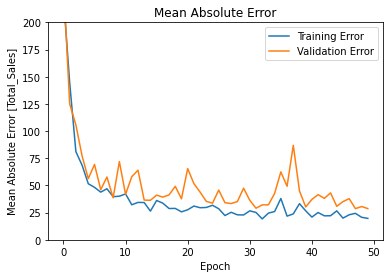

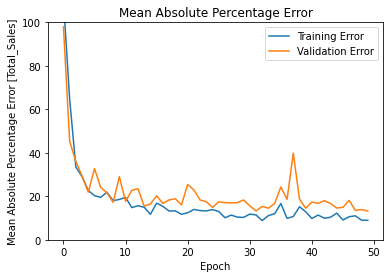

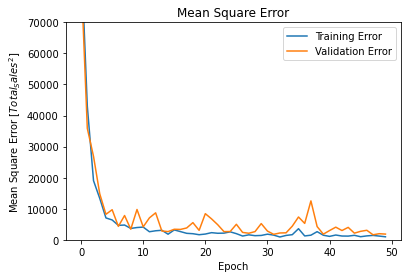

In [58]:
# Plotting KPI metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mae'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.ylim([0,200])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Percentage Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mape'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mape'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Percentage Error')
    plt.ylim([0,100])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Total_Sales^2$]')
    plt.plot(hist['epoch'], hist['mse'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.title('Mean Square Error')
    plt.ylim([0,70000])
    

    
plot_history(history)

**The plots shows absolute error increasing for validation error. This is an example of overfitting.**

In [59]:
# Calculating Metrics
loss, mae, mape, mse = hypermodel.evaluate(norm_test, testlabel, verbose=0)

print('Testing Set Mean Absolute Error: {:5.2f} Total_Sales'.format(mae))
print('Testing Set Mean Absolute Percentage Error: {:5.2f} Total_Sales'.format(mape))
print('Testing Set Mean Squared Error: {:5.2f} Total_Sales'.format(mse))

Testing Set Mean Absolute Error: 37.07 Total_Sales
Testing Set Mean Absolute Percentage Error: 16.55 Total_Sales
Testing Set Mean Squared Error: 3069.32 Total_Sales


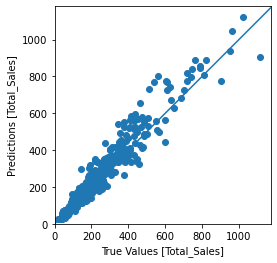

In [60]:
predictions = hypermodel.predict(norm_test).flatten()

plt.scatter(testlabel,predictions)
plt.xlabel('True Values [Total_Sales]')
plt.ylabel('Predictions [Total_Sales]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0,5000], [0,5000])

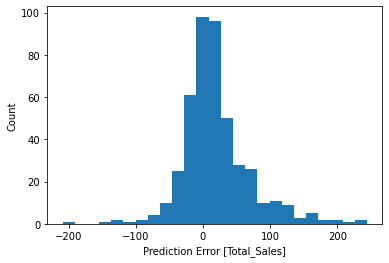

In [61]:
#Histogram of errors
error = predictions - testlabel
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Total_Sales]')
_ = plt.ylabel('Count')

In [62]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 352)               19008     
_________________________________________________________________
dense_1 (Dense)              (None, 352)               124256    
_________________________________________________________________
dense_2 (Dense)              (None, 224)               79072     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               50400     
_________________________________________________________________
dense_4 (Dense)              (None, 96)                21600     
_________________________________________________________________
dense_5 (Dense)              (None, 416)               40352     
_________________________________________________________________
dense_6 (Dense)              (None, 224)               9

In [63]:
# Reindexing for plot
predictions1 = pd.Series(predictions)

testlabel1 = testlabel
testlabel1.index = predictions1.index

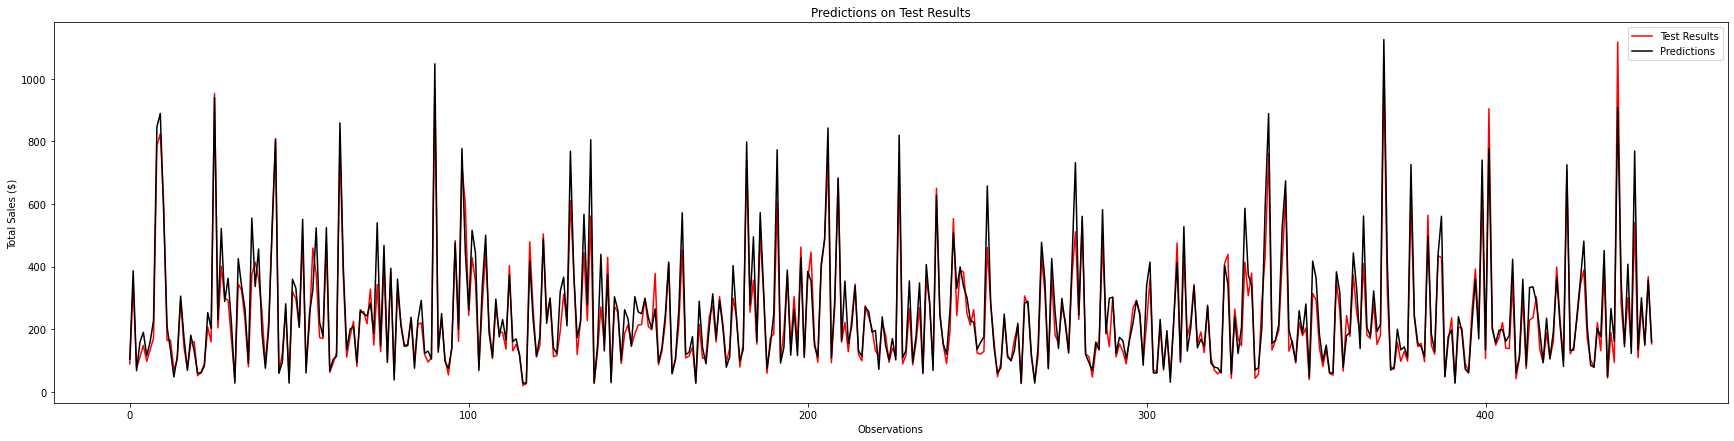

In [64]:
#Plotting predictions
x = list(range(0,450))
plt.figure(figsize=(30,7))
plt.plot(x, testlabel1, 'r', label='Test Results')
plt.plot(x, predictions1, '-k', label='Predictions')
plt.xlabel('Observations')
plt.ylabel('Total Sales ($)')
plt.title('Predictions on Test Results')
plt.legend()
plt.savefig('1D_toyotacovid_Graph.pdf')
plt.show()